In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
#Import global confirmed cases
data = pd.read_csv('COVIDGlobalConfirmed.txt')
data = pd.concat([data.iloc[:, 1:2], data.iloc[:, 4:]], axis = 1)
data = data.set_index('Country/Region')

#Calculate new cases from total cases
data2 = data.diff(axis = 1).iloc[:, 1:]

#Keep only regions with more than 500 total cases
data3 = data2[data2.sum(axis = 1) > 500]

#Focus on regions with fewer than 15 new cases in the past 3 days
data4 = data3[data3.iloc[:, -3:].sum(axis = 1) < 15]

#Reshape data for plotting
data5 = data4.T.reset_index()
data5['index'] = pd.to_datetime(data5['index'])
data5 = data5.iloc[:, :-1]

In [83]:
#Create template for cleaning data
c1 = pd.concat([data5['index'], data5.iloc[:, 1:2]], axis = 1)
c1['country'] = c1.columns[1] + str(0)
c1.columns = ['index', 'new', 'country']
c1 = c1[c1['index'] >= c1[c1['new'] > 0]['index'].min()]
c1 = c1[c1['index'] <= c1[c1['new'] > 1]['index'].max()]
c1['prevTtl'] = c1['new'].cumsum() - c1['new']
c1['prevNew'] = c1.new.shift(1)
c1 = c1.fillna(0)
c1['rel2Peak'] = c1['index'] - c1[c1['new'] == c1['new'].max()]['index'].min()
r2p = []
for i in range(len(c1['rel2Peak'])):
    r = c1['rel2Peak'][i].days
    r2p.append(r)
c1['rel2Peak'] = r2p
c1['peak'] = c1[c1['new'] == c1['new'].max()]['new'].values[0]

#Clean and reshape data for plotting
forPlot = c1

for i in range(data5.shape[1] - 3):
    c = pd.concat([data5['index'], data5.iloc[:, i+2:i+3]], axis = 1)
    c['country'] = c.columns[1] + str(i+1)
    c.columns = ['index', 'new', 'country']
    c = c[c['index'] >= c[c['new'] > 0]['index'].min()]
    c = c[c['index'] <= c[c['new'] > 1]['index'].max()]
    c['prevTtl'] = c['new'].cumsum() - c['new']
    c['prevNew'] = c.new.shift(1)
    c = c.fillna(0)
    c['rel2Peak'] = c['index'] - c[c['new'] == c['new'].max()]['index'].min()
    r2p = []
    for k in range(len(c['rel2Peak'])):
        r = c['rel2Peak'].iloc[k].days
        r2p.append(r)
    c['rel2Peak'] = r2p
    c['peak'] = c[c['new'] == c['new'].max()]['new'].values[0]
    forPlot = pd.concat([forPlot, c])
    
#View a plot of the data
fig = px.scatter(forPlot[forPlot['country'] != 'China5'], x='index', y='new', color = 'country', trendline="lowess")
fig.show()

#Create a first wave dataset prior to march first
c1A = pd.concat([data5['index'], data5.iloc[:, 1:2]], axis = 1)
c1A['country'] = c1A.columns[1] + str(0)
c1A.columns = ['index', 'new', 'country']
c1A = c1A[c1A['index'] >= c1A[c1A['new'] > 0]['index'].min()]
c1A = c1A[c1A['index'] <= pd.to_datetime('3/1/20')]
c1A = c1A[c1A['index'] <= c1A[c1A['new'] > 1]['index'].max()]
c1A['prevTtl'] = c1A['new'].cumsum() - c1A['new']
c1A['prevNew'] = c1A.new.shift(1)
c1A = c1A.fillna(0)
c1A['rel2Peak'] = c1A['index'] - c1A[c1A['new'] == c1A['new'].max()]['index'].min()
r2p = []
for i in range(len(c1A['rel2Peak'])):
    r = c1A['rel2Peak'][i].days
    r2p.append(r)
c1A['rel2Peak'] = r2p
c1A['peak'] = c1A[c1A['new'] == c1A['new'].max()]['new'].values[0]

#Clean and reshape data for plotting
forPlotA = c1A

for i in range(data5.shape[1] - 3):
    c = pd.concat([data5['index'], data5.iloc[:, i+2:i+3]], axis = 1)
    c['country'] = c.columns[1] + str(i+1)
    c.columns = ['index', 'new', 'country']
    c = c[c['index'] >= c[c['new'] > 0]['index'].min()]
    c = c[c['index'] <= pd.to_datetime('3/1/20')]
    c = c[c['index'] <= c[c['new'] > 1]['index'].max()]
    c['prevTtl'] = c['new'].cumsum() - c['new']
    c['prevNew'] = c.new.shift(1)
    c = c.fillna(0)
    c['rel2Peak'] = c['index'] - c[c['new'] == c['new'].max()]['index'].min()
    r2p = []
    for k in range(len(c['rel2Peak'])):
        r = c['rel2Peak'].iloc[k].days
        r2p.append(r)
    c['rel2Peak'] = r2p
    c['peak'] = c[c['new'] == c['new'].max()]['new'].values[0]
    forPlot = pd.concat([forPlot, c])
    forPlotA = pd.concat([forPlotA, c])
    
#View a plot of the data
fig = px.scatter(forPlotA[forPlotA['country'] != 'China5'], x='index', y='new', color = 'country', trendline="lowess")
fig.show()

In [84]:
#Seperate X and y for model fitting
forPlotA.columns = ['date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
forPlotA = forPlotA.reset_index()
forPlotA.columns = ['day', 'date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak']
X = pd.concat([forPlotA['day'], forPlotA.iloc[:, 4:]], axis = 1)
y = forPlotA['new']

#Fit regular linear regression for base comparison
model = LinearRegression().fit(X, y)
p = model.predict(X)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  557843.4786226975 MAE:  123.68922885713188 R2:  0.366535189237868


In [85]:
#Attempt linear regression after adding interaction terms
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X)

model = LinearRegression().fit(X_inter, y)
p = model.predict(X_inter)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X_inter, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  242864.72077006032 MAE:  138.65100578561115 R2:  0.7242125071296931


In [106]:
#Attempt to fit after moving China5 data
newDF = forPlotA[forPlotA['country'] != 'China5']

X = pd.concat([newDF['day'], newDF.iloc[:, 4:]], axis = 1)
y = newDF['new']

#Fit regular linear regression for base comparison
model = LinearRegression().fit(X, y)
p = model.predict(X)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  267.0196856482441 MAE:  8.449962105702285 R2:  0.5523495799488347


In [107]:
#Check fit without China5 and with interaction terms
X_inter = interaction.fit_transform(X)

model = LinearRegression().fit(X_inter, y)
p = model.predict(X_inter)
mse = sum((y - p)**2)/len(p)
mae = sum(np.abs(y - p))/len(y)
R2 = model.score(X_inter, y)

print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

MSE:  158.39876431648935 MAE:  7.381038244853434 R2:  0.7344492665036276


MSE:  93.64074420887638 MAE:  7.99432374190243 R2:  0.803188729100236


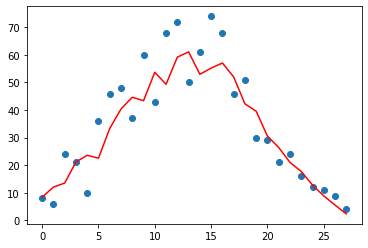

In [108]:
#Perform visual check on individual regions

#Isolate data for china0
china0 = forPlotA[forPlotA['country'] == 'China0']

#Seperate xs and ys
X = pd.concat([china0['day'], china0.iloc[:, 4:]], axis = 1)
y = china0['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  34.86849645125684 MAE:  4.484408188414837 R2:  0.5531036022855753


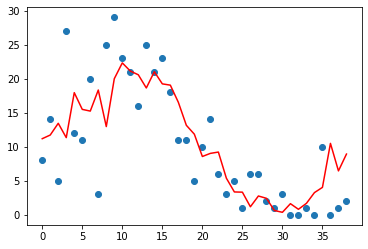

In [109]:
#Isolate data for china1
china1 = forPlotA[forPlotA['country'] == 'China1']

#Seperate xs and ys
X = pd.concat([china1['day'], china1.iloc[:, 4:]], axis = 1)
y = china1['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  120.278134807095 MAE:  9.41254320150621 R2:  0.34155831149947724


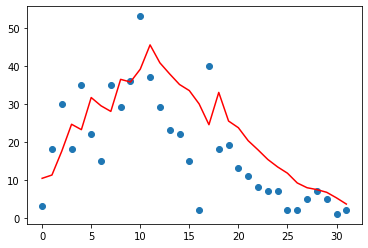

In [110]:
#Isolate data for china2
china2 = forPlotA[forPlotA['country'] == 'China2']

#Seperate xs and ys
X = pd.concat([china2['day'], china2.iloc[:, 4:]], axis = 1)
y = china2['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  692423979953815.0 MAE:  11554418.299294204 R2:  -109058262.21112536


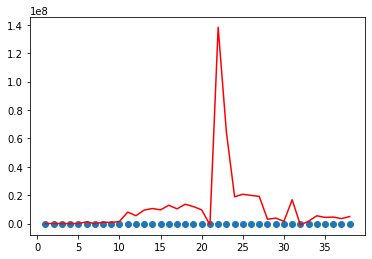

In [111]:
#Isolate data for china5
china5 = forPlotA[forPlotA['country'] == 'China5']

#Seperate xs and ys
X = pd.concat([china5['day'], china5.iloc[:, 4:]], axis = 1)
y = china5['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  205.68365381711962 MAE:  10.391478704110582 R2:  0.633356195361231


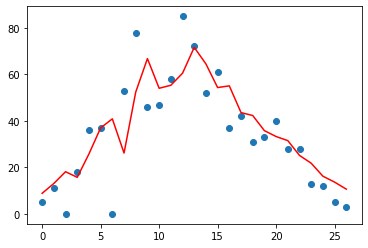

In [112]:
#Isolate data for china8
china8 = forPlotA[forPlotA['country'] == 'China8']

#Seperate xs and ys
X = pd.concat([china8['day'], china8.iloc[:, 4:]], axis = 1)
y = china8['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')

MSE:  29.697279205554842 MAE:  4.549303529296122 R2:  0.6806668926244985


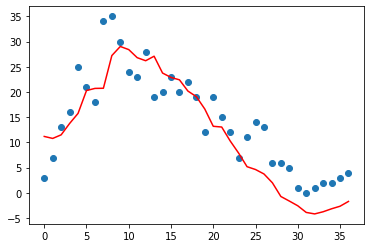

In [113]:
#Isolate data for china11
china11 = forPlotA[forPlotA['country'] == 'China11']

#Seperate xs and ys
X = pd.concat([china11['day'], china11.iloc[:, 4:]], axis = 1)
y = china11['new']

#Add interaction terms
X_inter = interaction.fit_transform(X)

#Get model predictions
preds = model.predict(X_inter)

#Calculate and print metrics
mse = sum((y - preds)**2)/len(y)
mae = sum(np.abs(y - preds))/len(y)
R2 = model.score(X_inter, y)
print("MSE: ", mse, "MAE: ", mae, "R2: ", R2)

#Perform visual check by plotting actuals and predictions
plt.scatter(X['day'], y)
plt.plot(X['day'], preds, color = 'r')